In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    
    crop_depth = 6
    random_shift = random.randint(0, 2)
    layer_shift = [0, 2, 4, 6, 8]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 25  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    for layer in range(image.shape[2]):
        image_=image[:,:,layer]
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
        cl1 = clahe.apply(image_)
        image[:,:,layer]=cl1
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



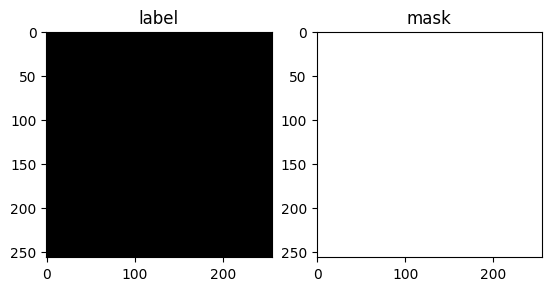

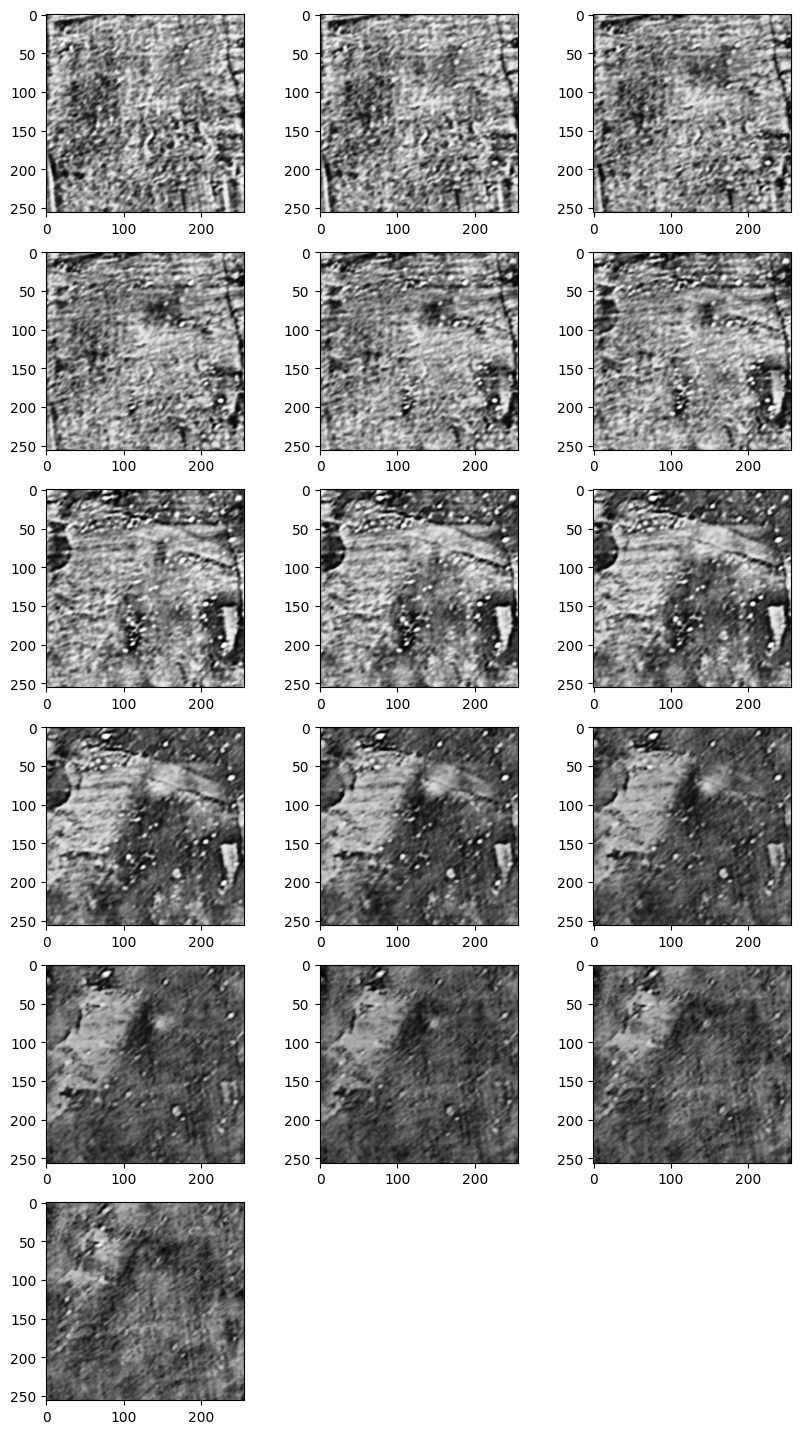

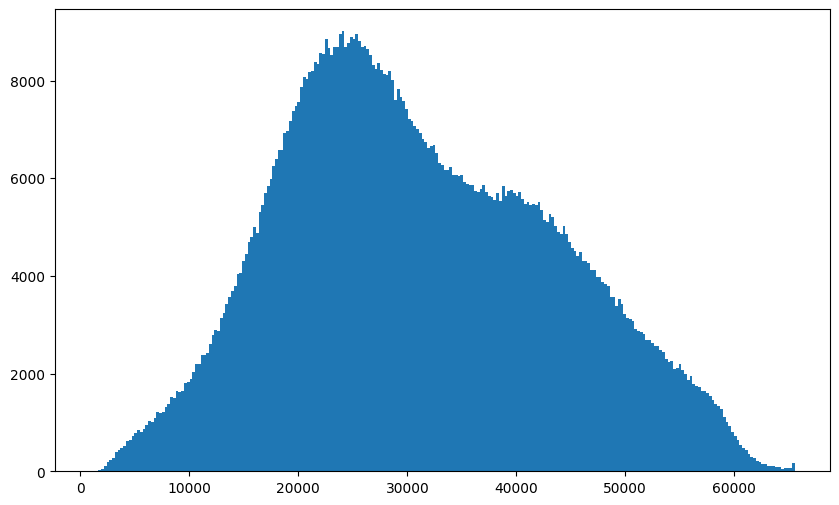

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [5]:
class SmpUnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]
        decoder2_dim = [128, 64, 32, ]
        self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = CFG.random_shift
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


### Training

In [7]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    if fold_i == 0:continue
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 1


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 0.9969: 100%|██████████| 177/177 [04:06<00:00,  1.39s/it]
Val Loss: 0.6676: 100%|██████████| 46/46 [00:15<00:00,  2.91it/s]


FBeta : 0.3663	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6128: 100%|██████████| 177/177 [03:57<00:00,  1.34s/it]
Val Loss: 0.3305: 100%|██████████| 46/46 [00:20<00:00,  2.25it/s]


FBeta : 0.2781



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5169: 100%|██████████| 177/177 [03:20<00:00,  1.13s/it]
Val Loss: 0.3264: 100%|██████████| 46/46 [00:15<00:00,  2.97it/s]


FBeta : 0.4266	SAVED MODEL



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4812: 100%|██████████| 177/177 [03:36<00:00,  1.22s/it]
Val Loss: 0.4206: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


FBeta : 0.3555



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4597: 100%|██████████| 177/177 [03:43<00:00,  1.26s/it]
Val Loss: 0.3028: 100%|██████████| 46/46 [00:18<00:00,  2.43it/s]


FBeta : 0.3524



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4410: 100%|██████████| 177/177 [03:52<00:00,  1.31s/it]
Val Loss: 0.2537: 100%|██████████| 46/46 [00:15<00:00,  3.00it/s]


FBeta : 0.5616	SAVED MODEL



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4184: 100%|██████████| 177/177 [03:11<00:00,  1.08s/it]
Val Loss: 0.2990: 100%|██████████| 46/46 [00:15<00:00,  3.00it/s]


FBeta : 0.3918



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4138: 100%|██████████| 177/177 [03:10<00:00,  1.08s/it]
Val Loss: 0.2828: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s]


FBeta : 0.5007



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3954: 100%|██████████| 177/177 [03:16<00:00,  1.11s/it]
Val Loss: 0.2719: 100%|██████████| 46/46 [00:14<00:00,  3.18it/s]


FBeta : 0.5906	SAVED MODEL



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3805: 100%|██████████| 177/177 [03:58<00:00,  1.35s/it]
Val Loss: 0.2887: 100%|██████████| 46/46 [00:20<00:00,  2.26it/s]


FBeta : 0.5458



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3714: 100%|██████████| 177/177 [03:52<00:00,  1.31s/it]
Val Loss: 0.2740: 100%|██████████| 46/46 [00:20<00:00,  2.29it/s]


FBeta : 0.5377



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3581: 100%|██████████| 177/177 [03:30<00:00,  1.19s/it]
Val Loss: 0.2712: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.5275



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3472: 100%|██████████| 177/177 [03:11<00:00,  1.08s/it]
Val Loss: 0.2796: 100%|██████████| 46/46 [00:15<00:00,  3.00it/s]


FBeta : 0.5990	SAVED MODEL



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3317: 100%|██████████| 177/177 [03:11<00:00,  1.08s/it]
Val Loss: 0.2674: 100%|██████████| 46/46 [00:15<00:00,  3.00it/s]


FBeta : 0.5692



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3182: 100%|██████████| 177/177 [03:11<00:00,  1.08s/it]
Val Loss: 0.2706: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.5724



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3064: 100%|██████████| 177/177 [03:10<00:00,  1.08s/it]
Val Loss: 0.2900: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


FBeta : 0.6180	SAVED MODEL



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2968: 100%|██████████| 177/177 [03:11<00:00,  1.08s/it]
Val Loss: 0.2488: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s]


FBeta : 0.6157



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2835: 100%|██████████| 177/177 [03:10<00:00,  1.08s/it]
Val Loss: 0.2916: 100%|██████████| 46/46 [00:15<00:00,  3.01it/s]


FBeta : 0.6114



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2748: 100%|██████████| 177/177 [03:10<00:00,  1.08s/it]
Val Loss: 0.2921: 100%|██████████| 46/46 [00:15<00:00,  3.01it/s]


FBeta : 0.6337	SAVED MODEL



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2639: 100%|██████████| 177/177 [03:10<00:00,  1.08s/it]
Val Loss: 0.2771: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


FBeta : 0.6216



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2548: 100%|██████████| 177/177 [03:18<00:00,  1.12s/it]
Val Loss: 0.2839: 100%|██████████| 46/46 [00:17<00:00,  2.69it/s]


FBeta : 0.6003



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2467: 100%|██████████| 177/177 [03:17<00:00,  1.11s/it]
Val Loss: 0.2821: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


FBeta : 0.6132



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2369: 100%|██████████| 177/177 [03:15<00:00,  1.11s/it]
Val Loss: 0.2889: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


FBeta : 0.6302



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2344: 100%|██████████| 177/177 [03:16<00:00,  1.11s/it]
Val Loss: 0.2990: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


FBeta : 0.6272



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2292: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.2906: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


FBeta : 0.6164

fold: 2


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0460: 100%|██████████| 177/177 [03:09<00:00,  1.07s/it]
Val Loss: 0.9209: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.4628	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5923: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.7949: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.0224



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4516: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6804: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.3208



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4092: 100%|██████████| 177/177 [03:05<00:00,  1.05s/it]
Val Loss: 0.7256: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.4902	SAVED MODEL



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3900: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6391: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.3943



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3751: 100%|██████████| 177/177 [03:05<00:00,  1.05s/it]
Val Loss: 0.6030: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


FBeta : 0.5698	SAVED MODEL



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3616: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6903: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.3923



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3497: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6471: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.5330



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3371: 100%|██████████| 177/177 [03:05<00:00,  1.05s/it]
Val Loss: 0.5840: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


FBeta : 0.5776	SAVED MODEL



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3246: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.5875: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.5808	SAVED MODEL



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3170: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6537: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5788



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3094: 100%|██████████| 177/177 [03:10<00:00,  1.08s/it]
Val Loss: 0.5818: 100%|██████████| 46/46 [00:15<00:00,  2.89it/s]


FBeta : 0.5909	SAVED MODEL



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3001: 100%|██████████| 177/177 [03:13<00:00,  1.09s/it]
Val Loss: 0.6420: 100%|██████████| 46/46 [00:14<00:00,  3.16it/s]


FBeta : 0.5867



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2874: 100%|██████████| 177/177 [03:36<00:00,  1.22s/it]
Val Loss: 0.5829: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6277	SAVED MODEL



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2812: 100%|██████████| 177/177 [03:35<00:00,  1.22s/it]
Val Loss: 0.5958: 100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


FBeta : 0.6426	SAVED MODEL



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2722: 100%|██████████| 177/177 [03:15<00:00,  1.11s/it]
Val Loss: 0.6643: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


FBeta : 0.6282



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2589: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6099: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.6235



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2536: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.6039: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.6121



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2423: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6511: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.6475	SAVED MODEL



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2370: 100%|██████████| 177/177 [03:07<00:00,  1.06s/it]
Val Loss: 0.7524: 100%|██████████| 46/46 [00:15<00:00,  3.07it/s]


FBeta : 0.6089



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2283: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.6205: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.6558	SAVED MODEL



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2210: 100%|██████████| 177/177 [03:15<00:00,  1.10s/it]
Val Loss: 0.6882: 100%|██████████| 46/46 [00:16<00:00,  2.82it/s]


FBeta : 0.6376



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2158: 100%|██████████| 177/177 [03:24<00:00,  1.16s/it]
Val Loss: 0.6579: 100%|██████████| 46/46 [00:16<00:00,  2.73it/s]


FBeta : 0.6617	SAVED MODEL



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2107: 100%|██████████| 177/177 [03:21<00:00,  1.14s/it]
Val Loss: 0.6276: 100%|██████████| 46/46 [00:16<00:00,  2.80it/s]


FBeta : 0.6652	SAVED MODEL



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2083: 100%|██████████| 177/177 [03:19<00:00,  1.13s/it]
Val Loss: 0.6508: 100%|██████████| 46/46 [00:16<00:00,  2.81it/s]


FBeta : 0.6588

fold: 3


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.0206: 100%|██████████| 177/177 [03:19<00:00,  1.13s/it]
Val Loss: 0.9163: 100%|██████████| 46/46 [00:15<00:00,  2.99it/s]


FBeta : 0.4198	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5745: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.7541: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.0000



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4521: 100%|██████████| 177/177 [03:05<00:00,  1.05s/it]
Val Loss: 0.9115: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.0135



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4207: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6264: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5319	SAVED MODEL



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3983: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.5585: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.5644	SAVED MODEL



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3851: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.5911: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.3882



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3687: 100%|██████████| 177/177 [03:05<00:00,  1.05s/it]
Val Loss: 0.5576: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5948	SAVED MODEL



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3584: 100%|██████████| 177/177 [03:05<00:00,  1.05s/it]
Val Loss: 0.8194: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.4474



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3484: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.5359: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.5930



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3378: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6052: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.5597



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3264: 100%|██████████| 177/177 [03:05<00:00,  1.05s/it]
Val Loss: 0.5492: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6156	SAVED MODEL



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3138: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6173: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.6758	SAVED MODEL



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3045: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.6135: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


FBeta : 0.6447



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2954: 100%|██████████| 177/177 [03:25<00:00,  1.16s/it]
Val Loss: 0.5480: 100%|██████████| 46/46 [00:17<00:00,  2.65it/s]


FBeta : 0.6362



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2825: 100%|██████████| 177/177 [03:31<00:00,  1.20s/it]
Val Loss: 0.5670: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


FBeta : 0.6111



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2750: 100%|██████████| 177/177 [03:37<00:00,  1.23s/it]
Val Loss: 0.5344: 100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


FBeta : 0.6407



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2635: 100%|██████████| 177/177 [03:11<00:00,  1.08s/it]
Val Loss: 0.5563: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6808	SAVED MODEL



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2527: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.6293: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6539



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2430: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.5629: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6856	SAVED MODEL



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2330: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.5697: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6884	SAVED MODEL



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2246: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.5373: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6853



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2205: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.5740: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6791



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2134: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
Val Loss: 0.5438: 100%|██████████| 46/46 [00:15<00:00,  3.04it/s]


FBeta : 0.6986	SAVED MODEL



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2077: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.5649: 100%|██████████| 46/46 [00:15<00:00,  3.05it/s]


FBeta : 0.6996	SAVED MODEL



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2066: 100%|██████████| 177/177 [03:06<00:00,  1.06s/it]
Val Loss: 0.5752: 100%|██████████| 46/46 [00:15<00:00,  3.06it/s]


FBeta : 0.6950

fold: 4


Epoch 0/25  Mem : 23.1GB  LR : 1.00E-04  Loss: 1.1934: 100%|██████████| 185/185 [03:15<00:00,  1.06s/it]
Val Loss: 0.9188: 100%|██████████| 38/38 [00:12<00:00,  2.96it/s]


FBeta : 0.3693	SAVED MODEL



Epoch 1/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.6951: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.4593: 100%|██████████| 38/38 [00:12<00:00,  3.05it/s]


FBeta : 0.4092	SAVED MODEL



Epoch 2/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.5155: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.4154: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.1523



Epoch 3/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4767: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3630: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]


FBeta : 0.5656	SAVED MODEL



Epoch 4/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4439: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3758: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]


FBeta : 0.4598



Epoch 5/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4333: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3687: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.6017	SAVED MODEL



Epoch 6/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4141: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3588: 100%|██████████| 38/38 [00:12<00:00,  3.04it/s]


FBeta : 0.5470



Epoch 7/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.4021: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.4334: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.2208



Epoch 8/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3921: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3866: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]


FBeta : 0.5793



Epoch 9/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3748: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3359: 100%|██████████| 38/38 [00:12<00:00,  3.04it/s]


FBeta : 0.6100	SAVED MODEL



Epoch 10/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3646: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.4918: 100%|██████████| 38/38 [00:12<00:00,  3.04it/s]


FBeta : 0.4682



Epoch 11/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3517: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3421: 100%|██████████| 38/38 [00:12<00:00,  3.02it/s]


FBeta : 0.6047



Epoch 12/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3449: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3371: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]


FBeta : 0.6292	SAVED MODEL



Epoch 13/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3303: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3334: 100%|██████████| 38/38 [00:12<00:00,  3.04it/s]


FBeta : 0.6215



Epoch 14/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3154: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3565: 100%|██████████| 38/38 [00:12<00:00,  3.02it/s]


FBeta : 0.5902



Epoch 15/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.3079: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3419: 100%|██████████| 38/38 [00:12<00:00,  3.05it/s]


FBeta : 0.6108



Epoch 16/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2959: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.4384: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]


FBeta : 0.4739



Epoch 17/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2801: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3942: 100%|██████████| 38/38 [00:12<00:00,  3.02it/s]


FBeta : 0.5248



Epoch 18/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2746: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3428: 100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


FBeta : 0.6247



Epoch 19/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2618: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3866: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]


FBeta : 0.5556



Epoch 20/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2544: 100%|██████████| 185/185 [03:26<00:00,  1.12s/it]
Val Loss: 0.3736: 100%|██████████| 38/38 [00:13<00:00,  2.73it/s]


FBeta : 0.6411	SAVED MODEL



Epoch 21/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2435: 100%|██████████| 185/185 [03:45<00:00,  1.22s/it]
Val Loss: 0.3580: 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]


FBeta : 0.5998



Epoch 22/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2362: 100%|██████████| 185/185 [03:40<00:00,  1.19s/it]
Val Loss: 0.3560: 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]


FBeta : 0.5932



Epoch 23/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2358: 100%|██████████| 185/185 [03:28<00:00,  1.13s/it]
Val Loss: 0.3555: 100%|██████████| 38/38 [00:12<00:00,  3.04it/s]


FBeta : 0.6119



Epoch 24/25  Mem : 23.1GB  LR : 1.00E-03  Loss: 0.2258: 100%|██████████| 185/185 [03:14<00:00,  1.05s/it]
Val Loss: 0.3668: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]


FBeta : 0.6035

{"status":200,"message":"ok"}

In [6]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.5956
fbeta: 0.6337
fbeta: 0.6652
fbeta: 0.6996
fbeta: 0.6411


In [9]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6467


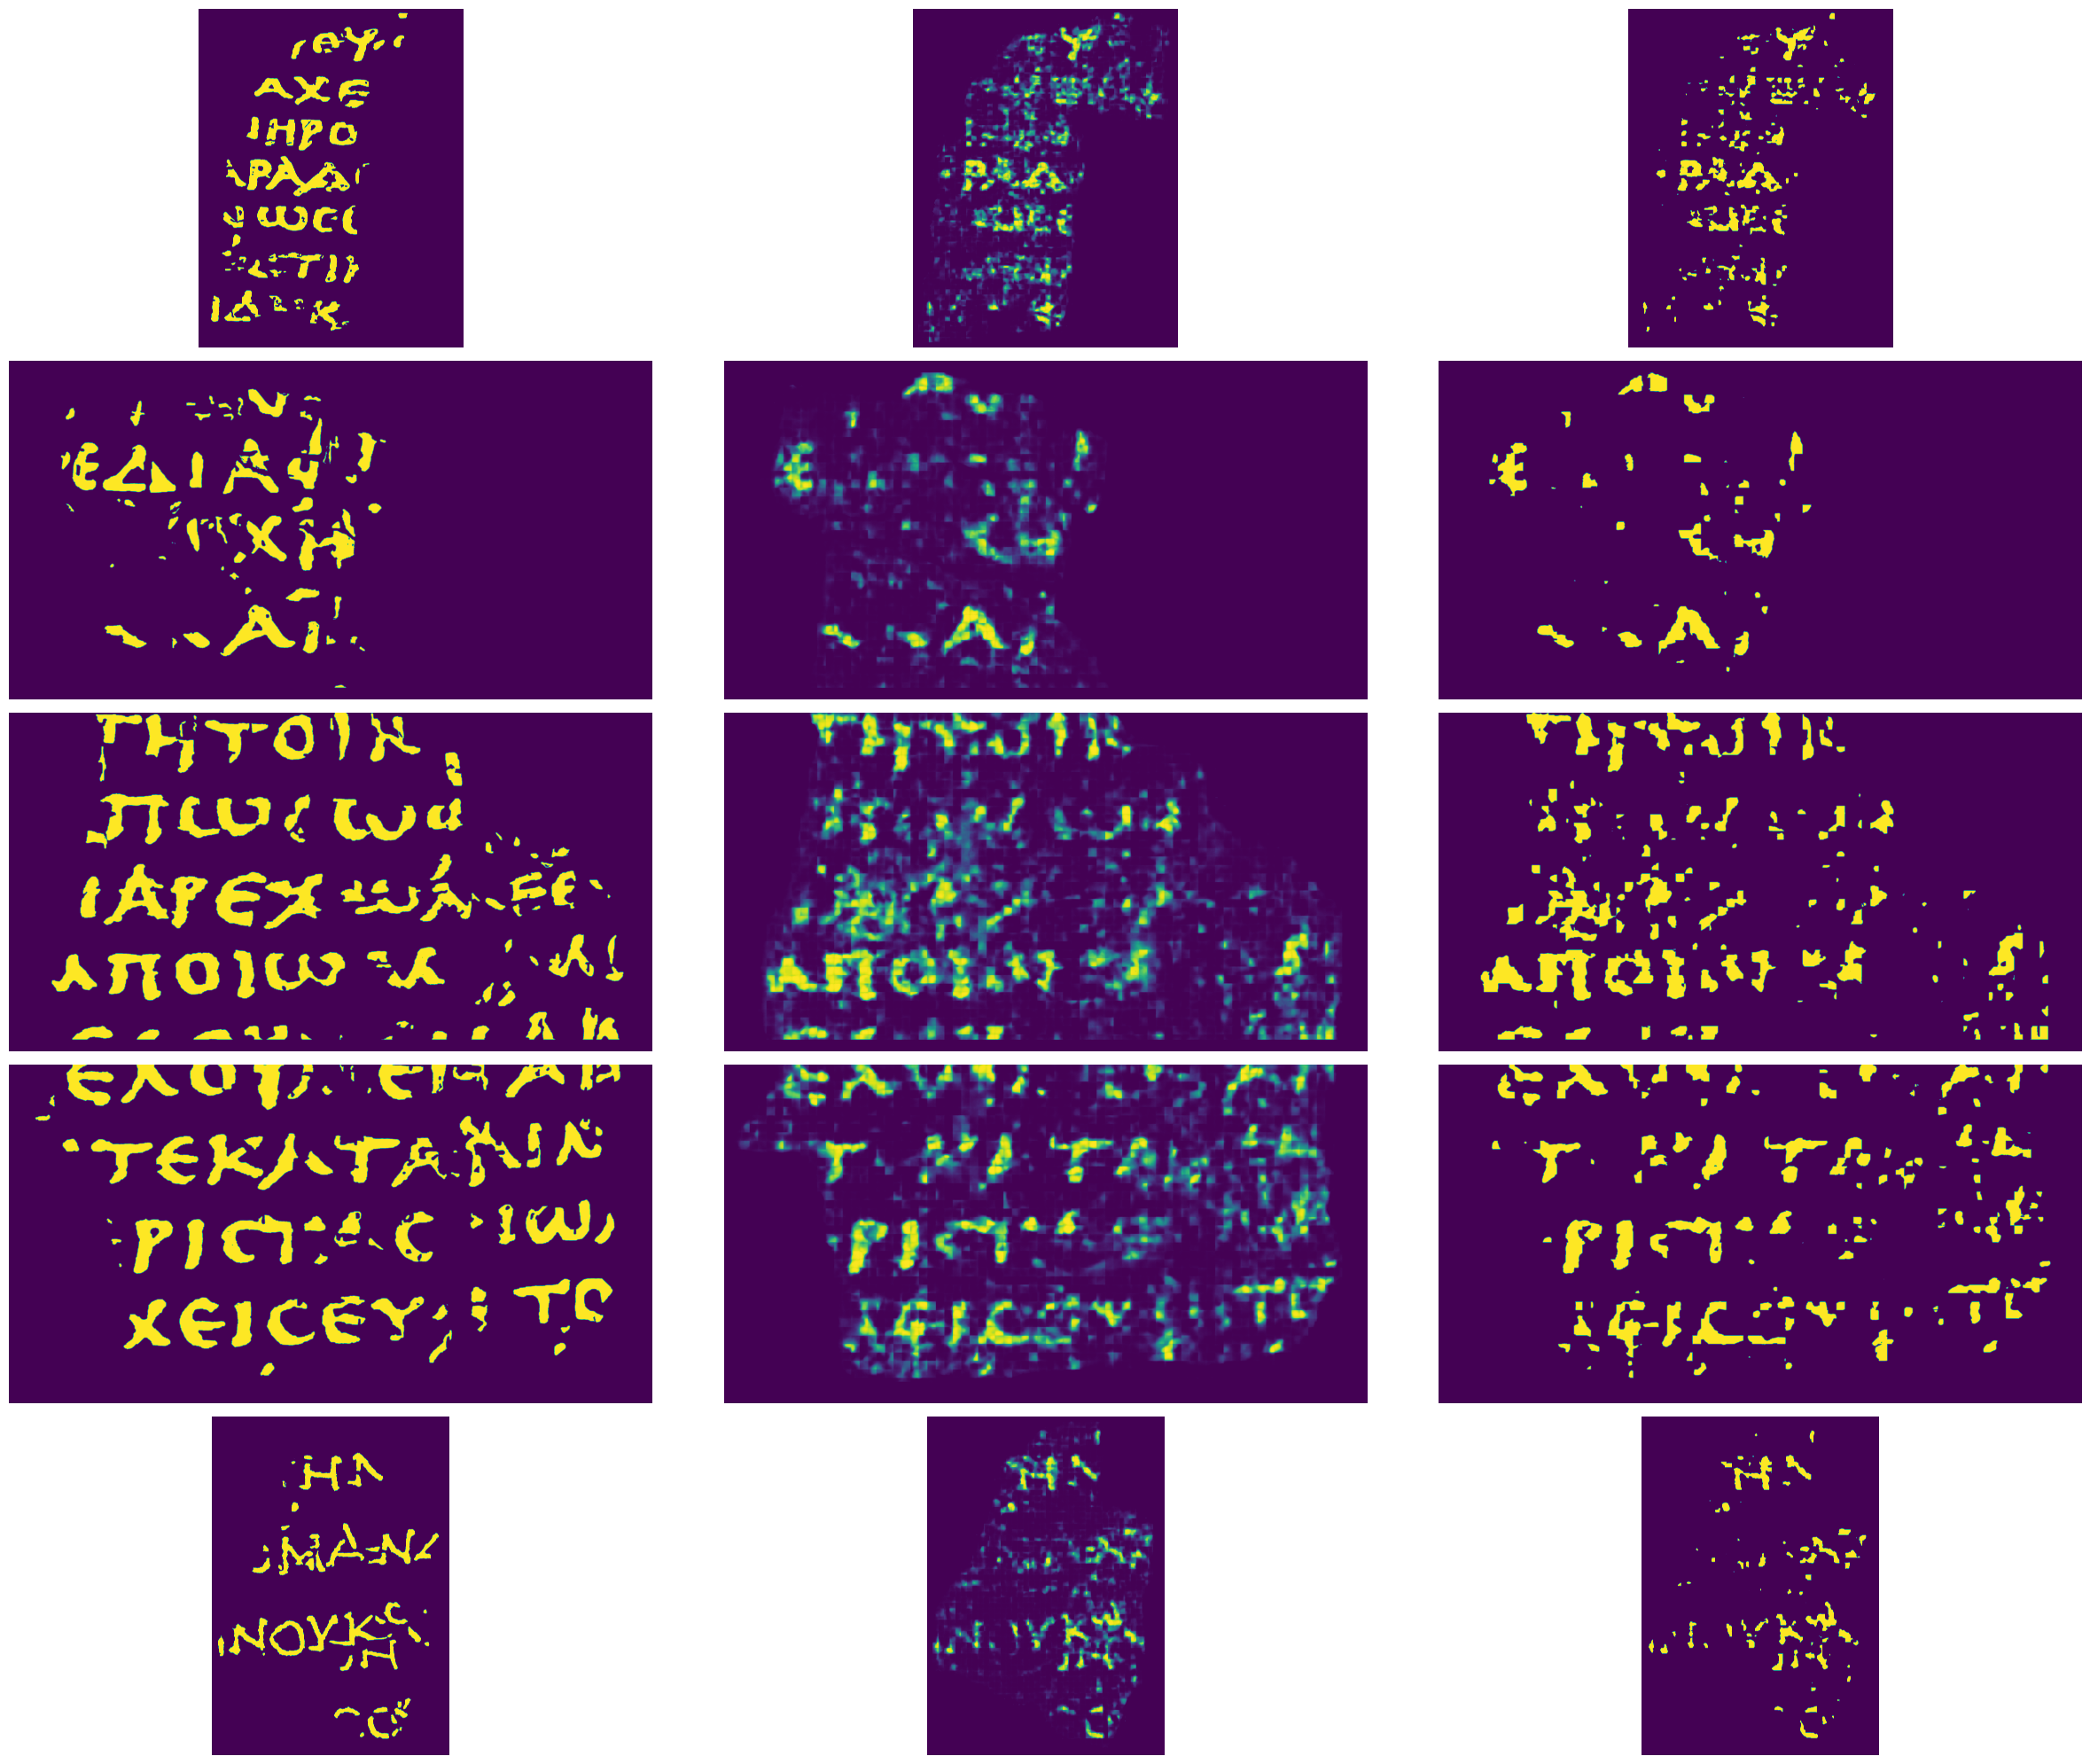

In [8]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)